In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dropout, RepeatVector, TimeDistributed, Dense
from keras.callbacks import EarlyStopping
import plotly.graph_objects as go
from tensorflow.keras.optimizers import Adam


df = pd.read_csv('/content/cpu_utilization_asg_misconfiguration (1).csv')
df = df[['time', 'value']]
df['time'] = pd.to_datetime(df['time'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['time'], y=df['value'], name='cpu usage'))
fig.update_layout(showlegend=True, title='cpu usage')
fig.show()

train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

# Scaling the data
scaler = StandardScaler()
train['value'] = scaler.fit_transform(train[['value']])
test['value'] = scaler.transform(test[['value']])

# Function to create dataset for LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10
# reshape to [samples, time_steps, n_features]
X_train, y_train = create_dataset(train[['value']], train.value, TIME_STEPS)
X_test, y_test = create_dataset(test[['value']], test.value, TIME_STEPS)

# LSTM Autoencoder model
model = Sequential()
model.add(LSTM(units=128, input_shape=(TIME_STEPS, 1), return_sequences=True))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(rate=0.2))

# LSTM layer to capture temporal dependencies
model.add(LSTM(units=128, return_sequences=False))  # Assuming you want to collapse sequences into a single context vector
model.add(RepeatVector(TIME_STEPS))

# Decoder
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(rate=0.2))

# TimeDistributed Dense layer for output at each time step
model.add(TimeDistributed(Dense(units=1)))
model.compile(optimizer=Adam(learning_rate=0.01), loss="mse")
model.summary()



(16245, 2) (1805, 2)


<ipython-input-91-9cc2807695b8>:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-91-9cc2807695b8>:30: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 10, 128)           66560     
                                                                 
 dense_12 (Dense)            (None, 10, 64)            8256      
                                                                 
 dropout_16 (Dropout)        (None, 10, 64)            0         
                                                                 
 lstm_18 (LSTM)              (None, 128)               98816     
                                                                 
 repeat_vector_9 (RepeatVec  (None, 10, 128)           0         
 tor)                                                            
                                                                 
 lstm_19 (LSTM)              (None, 10, 128)           131584    
                                                     

In [92]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1805 entries, 16245 to 18049
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1805 non-null   datetime64[ns]
 1   value   1805 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 28.3 KB


In [93]:
df.time

0       2014-05-14 01:14:00
1       2014-05-14 01:19:00
2       2014-05-14 01:24:00
3       2014-05-14 01:29:00
4       2014-05-14 01:34:00
                ...        
18045   2014-07-15 16:59:00
18046   2014-07-15 17:04:00
18047   2014-07-15 17:09:00
18048   2014-07-15 17:14:00
18049   2014-07-15 17:19:00
Name: time, Length: 18050, dtype: datetime64[ns]

Epoch 1/50
457/457 [==============================] - 42s 77ms/step - loss: 0.3889 - val_loss: 0.5073
Epoch 2/50
  3/457 [..............................] - ETA: 20s - loss: 0.1693

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



457/457 [==============================] - 29s 63ms/step - loss: 0.1530 - val_loss: 0.0359
Epoch 3/50
457/457 [==============================] - 29s 63ms/step - loss: 0.1168 - val_loss: 0.0525
Epoch 4/50
457/457 [==============================] - 30s 65ms/step - loss: 0.0804 - val_loss: 0.0187
Epoch 5/50
457/457 [==============================] - 30s 65ms/step - loss: 0.0589 - val_loss: 0.0315
Epoch 6/50
457/457 [==============================] - 29s 64ms/step - loss: 0.0541 - val_loss: 0.0400
Epoch 7/50
457/457 [==============================] - 31s 67ms/step - loss: 0.0578 - val_loss: 0.0309
Epoch 8/50
457/457 [==============================] - 31s 68ms/step - loss: 0.0559 - val_loss: 0.0321
Epoch 9/50
457/457 [==============================] - 28s 62ms/step - loss: 0.0611 - val_loss: 0.0301


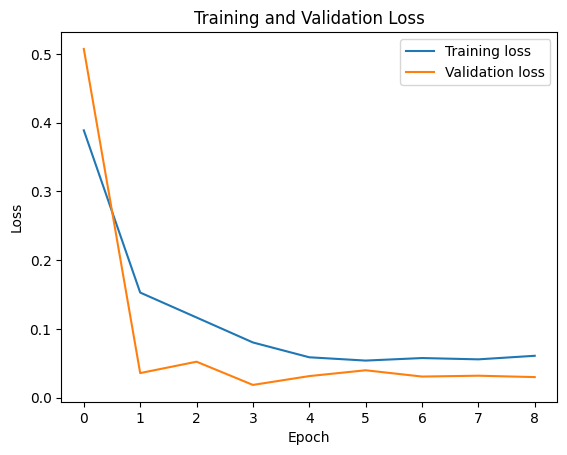

In [94]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, mode='min'),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
]

# Training the model
history = model.fit(
    X_train, X_train,  # Autoencoder: input and output are the same
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=callbacks,
    shuffle=False
)

# Plotting training and validation losses
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

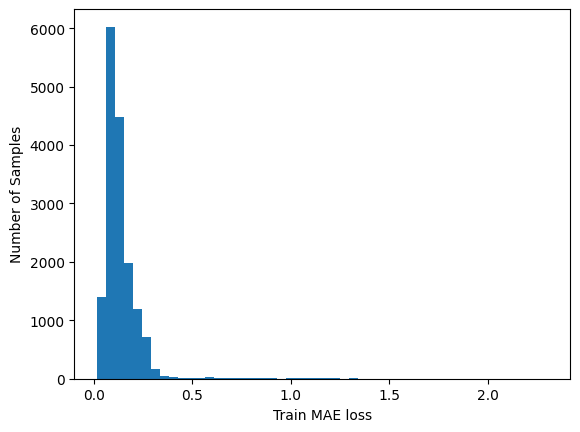

In [117]:
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

In [109]:
# Calculate MAE loss for train set to set threshold
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

# Set reconstruction error threshold
THRESHOLD = np.max(train_mae_loss)*0.78

print('Reconstruction error threshold:', THRESHOLD)

# Predict on test set and calculate MAE loss
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

508/508 [==============================] - 15s 29ms/step
Reconstruction error threshold: 1.7987435193670187
57/57 [==============================] - 1s 21ms/step


In [110]:
# Create DataFrame to store results with time index
test_score_df = pd.DataFrame(index=test.index[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['value'] = test[TIME_STEPS:].value
test_score_df['time']=df[TIME_STEPS:].time

# Visualize test loss vs threshold with time
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df.time, y=test_score_df.loss, name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df.time, y=test_score_df.threshold, name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

# Identify anomalies
anomalies = test_score_df[test_score_df.anomaly]




In [111]:
anomalies

,loss,threshold,anomaly,value,time
17021,1.866606,1.798744,True,1.754357,2014-07-12 03:39:00
17237,1.841663,1.798744,True,1.754357,2014-07-12 21:39:00
17787,1.802144,1.798744,True,2.466349,2014-07-14 19:29:00


In [112]:
# Visualize detected anomalies with time
fig = go.Figure()
fig.add_trace(go.Scatter(x=test.time[TIME_STEPS:], y=test[TIME_STEPS:].value, mode='lines', name='cpu usage'))
fig.add_trace(go.Scatter(x=anomalies.time, y=anomalies.value, mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()


In [119]:
from datetime import datetime, timedelta
import pandas as pd
import plotly.graph_objects as go

# Function to evaluate anomalies
def evaluate_anomalies(true_anomalies, detected_anomalies, time_window_hours=4):
    time_window = timedelta(hours=time_window_hours)

    # Convert string timestamps to datetime objects
    true_anomalies = [datetime.strptime(ts, "%Y-%m-%d %H:%M:%S.%f") for ts in true_anomalies]
    detected_anomalies = [datetime.strptime(ts, "%Y-%m-%d %H:%M:%S.%f") for ts in detected_anomalies]

    # Initialize counters
    true_positive = 0
    false_positive = 0
    false_negative = 0

    # Check each detected anomaly
    for detected in detected_anomalies:
        is_detected = False
        for true_anomaly in true_anomalies:
            if true_anomaly - time_window <= detected <= true_anomaly + time_window:
                is_detected = True
                true_positive += 1
                break

        if not is_detected:
            false_positive += 1

    # Calculate false negatives
    false_negative = len(true_anomalies) - true_positive

    # Calculate precision, recall, and F1 score
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "True Positives": true_positive,
        "False Positives": false_positive,
        "False Negatives": false_negative,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score
    }

# Assuming `test_score_df` is already defined and has a DateTimeIndex

# True anomalies and detected anomalies (timestamps adjusted to match the format in `labels.csv`)
true_anomalies = ['2014-07-12 02:04:00.000000', '2014-07-14 21:44:00.000000']

# Ensure the index is in datetime format
test_score_df.index = pd.to_datetime(test_score_df.time)

# Format detected anomaly timestamps
detected_anomalies = test_score_df[test_score_df.anomaly].index.strftime("%Y-%m-%d %H:%M:%S.%f").tolist()

# Evaluate the model considering ±4 hours tolerance
results = evaluate_anomalies(true_anomalies, detected_anomalies, time_window_hours=4)

# Print the results
print("Evaluation Results:")
print(f"True Positives: {results['True Positives']}")
print(f"False Positives: {results['False Positives']}")
print(f"False Negatives: {results['False Negatives']}")
print(f"Precision: {results['Precision']:.2f}")
print(f"Recall: {results['Recall']:.2f}")
print(f"F1 Score: {results['F1 Score']:.2f}")

# Visualize detected anomalies with time
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df.index, y=test_score_df.value, mode='lines', name='CPU Usage'))
fig.add_trace(go.Scatter(x=test_score_df[test_score_df.anomaly].index, y=test_score_df[test_score_df.anomaly].value, mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected Anomalies')
fig.show()


Evaluation Results:
True Positives: 2
False Positives: 1
False Negatives: 0
Precision: 0.67
Recall: 1.00
F1 Score: 0.80
